# Trajectory Planning 
Computing the trajectory for a holonomic robot using polynomial functions. We obtain the desired trajectory by first using a polynomial of degree 4, and then as a fifth degree Bernstein polynomial. 

Let's get started then!

As usual, we first import the required libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

These functions give the output of our 4 variable polynomial for a value of t

In [2]:
def gen_output_t(a, t):
    final = []
    for t_val in t:
        total = 0
        for i in range(len(a)):
            temp = a[i] * (t_val**i)
            total += temp
        final.append(total)
    return final

def differentiate_a(a):
    a_new = [a[i] * i for i in range(len(a))]
    return a_new[1:]

## Formulating Ma = b 

In [3]:
tf = 5
t_cookie = 2  
t0 = 0
# To solve equation in the form M * a = b
# M array is constant across both x and y

M = [ [1, t0, t0**2, t0**3, t0**4],
        [0, 1, 2*t0, 3*t0**2, 4*t0**3],
        [1, tf**1, tf**2, tf**3, tf**4],
        [0, 1, 2*tf, 3*tf**2, 4*tf**3],
        [1, t_cookie, t_cookie**2, t_cookie**3, t_cookie**4]
    ]
M = np.array(M)

bx = np.array([3, 0, 9, 0, 1])
by = np.array([0, 0, 5, 0, 2.5])

Minv = np.linalg.inv(M)
ax = Minv @ bx
ay = Minv @ by

time = np.arange(0, 5.5, 0.1).tolist()

Getting (x,y) for each t. 

In [4]:
x = gen_output_t(ax, time)
y = gen_output_t(ay, time)

Defining the three known points:

In [5]:
xi = 3
yi = 0
xf = 9
yf = 5
x_cookie = 1
y_cookie = 2.5

## Plotting the trajectory

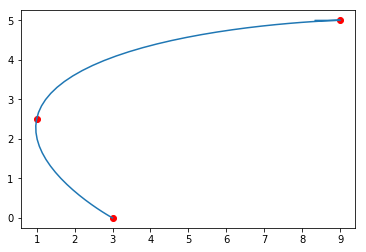

In [6]:
def plot(x,y):
    plt.figure()
    plt.plot(xi,yi, 'ro')
    plt.plot(xf,yf, 'ro')
    plt.plot(x_cookie,y_cookie, 'ro')
    plt.plot(x,y)
    plt.show()
plot(x,y)

In [7]:
diff_ax = differentiate_a(ax)
diff_ay = differentiate_a(ay)
x_vel = gen_output_t(diff_ax, time)
y_vel = gen_output_t(diff_ay, time)

### Plotting velocity and acceleration

<Figure size 432x288 with 0 Axes>

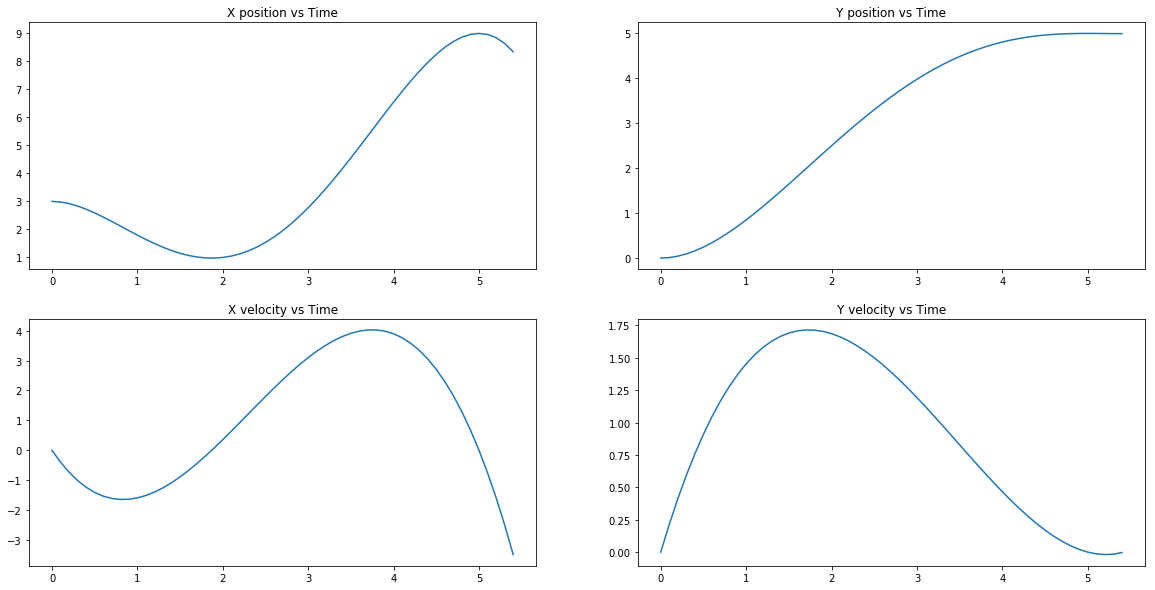

In [8]:
plt.figure()
figure(figsize=(20, 10))

plt.subplot(221)
plt.title("X position vs Time")
plt.plot(time, x)

plt.subplot(222)
plt.title("Y position vs Time")
plt.plot(time, y)

plt.subplot(223)
plt.title("X velocity vs Time")
plt.plot(time, x_vel) 

plt.subplot(224)
plt.title("Y velocity vs Time")
plt.plot(time, y_vel) # y velocity vs time